# In-Memory GiGL - Heterogeneous Graph Example

Latest version of this notebook can be found on [github](https://github.com/Snapchat/GiGL/blob/main/examples/tutorial/KDD_2025/heterogeneous_walkthrough.ipynb)


This notebook provides a walkthrough of preprocessing components with a small toy graph for GiGL's in-memory setting for training/inference. It will help you understand how each of these components perform in-memory training and inference.


## Overview Of Components
This notebook demonstrates the process of a simple, human-digestible graph being passed through all the pipeline components in GiGL in preparation for training to help understand how each of the components work.

The pipeline consists of the following components:

- **Config Populator**: Takes a template config and creates a frozen workflow config that dictates all inputs/outputs and business parameters that are read and used by each subsequent component. The template config contains the graph/task definitions and commands/classes you will use to run data preprocessor, trainer, and inferencer. The frozen template config will populate the template config with additional fields detailing where intermediate assets will be written to, such as the trained model and tfrecord output location, and is inferred based on the job name. 
    - Inputs:
        - `job_name`
        - `template_config.yaml`
        - `resource_config.yaml`
        - `Output Path[frozen_gbml_config.yaml]`
    - Output: `frozen_gbml_config.yaml`
&nbsp;

From here on our we will use `frozen_gbml_config.yaml` as input to subsequent components. This includes everything from `template_config.yaml` and paths to where components can store and read data from for inter-component data communication.

- **Data Preprocessor**: Transforms necessary node and edge feature assets as needed as a precursor step in most ML tasks according to the user-provided data preprocessor config class.
    - Inputs: 
        - `job_name`
        - `frozen_gbml_config.yaml` - from above
        - `resource_config.yaml`
        - `Optional[custom_worker_image_uri]` - if any custom user code, base image off of 
    - Output: PreprocessedMetadata Proto, which includes inferred GraphMetadata and preprocessed graph data Tfrecords after applying the user-defined preprocessing function.
&nbsp;

- **Trainer**: The trainer component reads the output of the data preprocessor and trains a model on the data, loading subgraphs on-the-fly by leveraging GiGL's distributed in-memory subgraph sampling capabilities.
    - Inputs: 
        - `frozen_gbml_config.yaml`
        - `resource_config.yaml`
    - Output: state_dict stored in trainedModelUri.
&nbsp;

- **Inferencer**: Runs inference of a trained model, leveraging the same distributed in-memory subgraph sampling capabilities, and writes the embeddings to BigQuery.
    - Input: 
        - `frozen_gbml_config.yaml`
        - `resource_config.yaml`
    - Output: Embeddings assets.
&nbsp;


In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress TensorFlow logs


from gigl.common.utils.jupyter_magics import change_working_dir_to_gigl_root
change_working_dir_to_gigl_root()

2025-08-01 20:26 [INFO] : Using Any for unsupported type: typing.Sequence[~T] (native_type_compatibility.py:convert_to_beam_type:340)


Changed working directory to: /home/svij/GiGL


## Visualize the dataset

First, let's visualize the toy graph :)

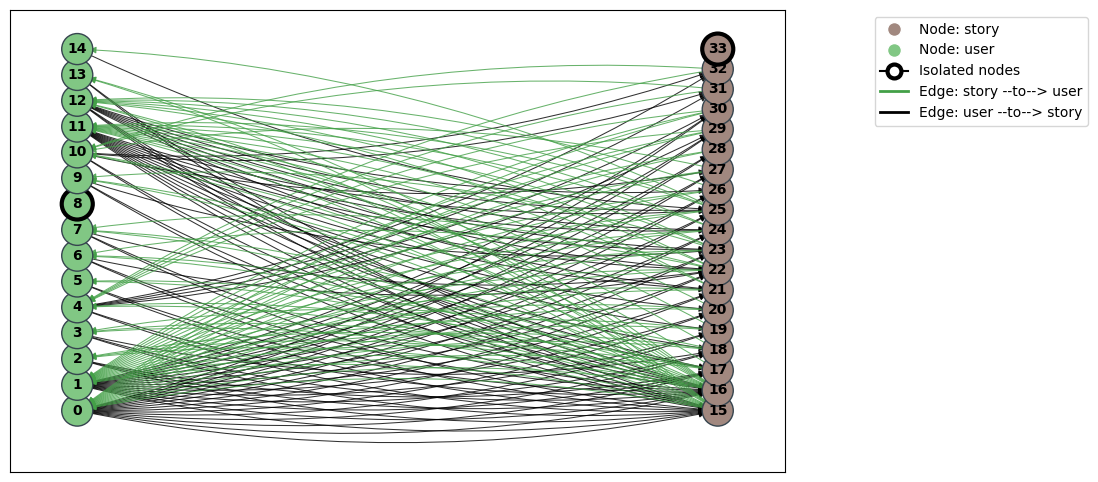

In [ ]:
from torch_geometric.data import HeteroData

from gigl.common.utils.jupyter_magics import GraphVisualizer
from gigl.src.mocking.toy_asset_mocker import load_toy_graph


original_graph_heterodata: HeteroData = load_toy_graph(graph_config_path="examples/tutorial/KDD_2025/graph_config.yaml")
# Visualize the graph
GraphVisualizer.visualize_graph(original_graph_heterodata)

# Note: Some limitations in our rendering code so you may not be seeing the real node_ids here; 
# but more for demonstration purposes

## Resource config setup.

If you are attending the GiGL tutorial at KDD'25 then you should run the below cells **in addtion to "Setting up Configs" to setup your resource config for a Qwiklabs project.

In [ ]:
import subprocess
project = subprocess.check_output(['gcloud', 'config', 'get-value', 'project']).decode("utf-8").strip()  # e.g. qwiklabs-gcp-02-5a342b5770cb

RESOURCE_CONFIG_URI = f"gs://gigl_perm_assets_{project}/in_memory_resource_config.yaml"

os.environ["PROJECT"] = project
os.environ["RESOURCE_CONFIG_PATH"] = RESOURCE_CONFIG_URI
os.environ["GIGL_TEST_DEFAULT_RESOURCE_CONFIG"] = RESOURCE_CONFIG_URI

print(f"Project: {project}, Resource config uri: {RESOURCE_CONFIG_URI}")


In [ ]:
%%bash
python  <(curl -s https://raw.githubusercontent.com/Snapchat/GiGL/refs/heads/main/scripts/bootstrap_resource_config.py) \
  --project="$PROJECT" \
  --region="us-central1" \
  --gcp_service_account_email="gigl-dev@$PROJECT.iam.gserviceaccount.com" \
  --docker_artifact_registry_path="us-central1-docker.pkg.dev/$PROJECT/gigl-base-images" \
  --temp_assets_bq_dataset_name="gigl_temp_assets" \
  --embedding_bq_dataset_name="gigl_embeddings" \
  --temp_assets_bucket="gs://gigl_temp_assets_$PROJECT" \
  --perm_assets_bucket="gs://gigl_perm_assets_$PROJECT" \
  --template_resource_config_uri="examples/tutorial/KDD_2025/resource_config.yaml" \
  --output_resource_config_path="$RESOURCE_CONFIG_PATH" \
  --force_shell_config_update=True

source ~/.bashrc

In [ ]:
# Let's look at the resource config we just created
!gsutil cat $RESOURCE_CONFIG_PATH

### Setting up Configs

The first thing we need to do is create the resource and task configs. 

- **Task Config**: Specifies task-related configurations, guiding the behavior of components according to the needs of your machine learning task. See [Task Config Guide](../../../docs/user_guide/config_guides/task_config_guide.md). For this task, we have already provided a task config: [task_config.yaml](./task_config.yaml).

- **Resource Config**: Details the resource allocation and environmental settings across all GiGL components. This encompasses shared resources for all components, as well as component-specific settings. See [Resource Config Guide](../../../docs/user_guide/config_guides/resource_config_guide.md). For this task, we provide a resource [resource_config.yaml](./resource_config.yaml). The provided default values in `shared_resource_config.common_compute_config` will need to be changed.

  - **Instructions to configure the resource config to work**:
    If you have not already, please follow the [Quick Start Guide](../../../docs/user_guide/getting_started/quick_start.md) to set up your cloud environment and create a default test resource config. You can then copy the relevant `shared_resource_config.common_compute_config` to [resource_config.yaml](./resource_config.yaml).

In [ ]:
import datetime
import getpass
import pathlib
import os


from gigl.common import Uri, UriFactory
from gigl.common.utils.gcs import GcsUri
from gigl.src.common.utils.file_loader import FileLoader
from gigl.common.constants import DEFAULT_GIGL_RELEASE_SRC_IMAGE_DATAFLOW_CPU, DEFAULT_GIGL_RELEASE_SRC_IMAGE_CUDA, DEFAULT_GIGL_RELEASE_SRC_IMAGE_CPU
from gigl.env.pipelines_config import get_resource_config
from gigl.src.common.types.pb_wrappers.gigl_resource_config import GiglResourceConfigWrapper

file_loader = FileLoader()

notebook_dir = pathlib.Path("./examples/tutorial/KDD_2025").as_posix() # We should be in root dir because of cell # 1

# You are welcome to customize these to point to your own configuration files.
JOB_NAME = f"{getpass.getuser()}_gigl_toy_example_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
TEMPLATE_TASK_CONFIG_PATH: Uri = UriFactory.create_uri(f"{notebook_dir}/task_config.yaml")
FROZEN_TASK_CONFIG_POINTER_FILE_PATH: Uri = UriFactory.create_uri(f"/tmp/GiGL/{JOB_NAME}/frozen_task_config.yaml")
pathlib.Path(FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri).parent.mkdir(parents=True, exist_ok=True)

resource_config_loaded_path: Uri = UriFactory.create_uri(os.environ.get("GIGL_TEST_DEFAULT_RESOURCE_CONFIG", f"{notebook_dir}/resource_config.yaml"))
if not isinstance(resource_config_loaded_path, GcsUri):
    # If our resource config is not already on GCS, we should upload the local resource so that we can it can be used in our VAI pipelines
    resource_config_wrapper: GiglResourceConfigWrapper = get_resource_config(
        resource_config_uri=resource_config_loaded_path
    )
    RESOURCE_CONFIG_PATH: Uri = UriFactory.create_uri(os.path.join(resource_config_wrapper.temp_assets_bucket_path.uri, f"{getpass.getuser()}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_example_resource_config.yaml"))
    file_loader.load_file(file_uri_src=resource_config_loaded_path, file_uri_dst=RESOURCE_CONFIG_PATH)
else:
    RESOURCE_CONFIG_PATH = resource_config_loaded_path

resource_config = get_resource_config(
        resource_config_uri=RESOURCE_CONFIG_PATH
) 

print(f"JOB_NAME: {JOB_NAME}")
print(f"TEMPLATE_TASK_CONFIG_PATH: {TEMPLATE_TASK_CONFIG_PATH.uri}")
print(f"FROZEN_TASK_CONFIG_POINTER_FILE_PATH: {FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri}")
print(f"RESOURCE_CONFIG_PATH: {RESOURCE_CONFIG_PATH.uri}")

os.environ["JOB_NAME"] = JOB_NAME
os.environ["TEMPLATE_TASK_CONFIG_PATH"] = TEMPLATE_TASK_CONFIG_PATH.uri
os.environ["FROZEN_TASK_CONFIG_POINTER_FILE_PATH"] = FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri
os.environ["RESOURCE_CONFIG_PATH"] = RESOURCE_CONFIG_PATH.uri

## Validating the Configs

We provide the ability to validate your resource and task configs. Although the validation is not exhaustive, it does help assert that the more common issues are not present before expensive compute is scheduled.

In [ ]:
from gigl.src.validation_check.config_validator import kfp_validation_checks

validator = kfp_validation_checks(
    job_name=JOB_NAME,
    task_config_uri=TEMPLATE_TASK_CONFIG_PATH,
    resource_config_uri=RESOURCE_CONFIG_PATH,
    start_at="config_populator",
)

### Config Populator

Takes in a template `GbmlConfig` and outputs a frozen `GbmlConfig` by populating all job-related metadata paths in `sharedConfig`. These are mostly GCS paths that the following components read and write from, and use as an intermediary data communication medium. For example, the field `sharedConfig.trainedModelMetadata.trained_model_uri` is populated with a GCS URI, which indicates to the Trainer to write the trained model to this path, and to the Inferencer to read the model from this path. See the full [Config Populator Guide](../../../docs/user_guide/overview/components/config_populator.md).

After running the command below, we will have created a frozen config and uploaded it to the `perm_assets_bucket` provided in the `resource config`. The path to that file will be stored in the URI in `FROZEN_TASK_CONFIG_POINTER_FILE_PATH`.

In [ ]:
!python -m \
    gigl.src.config_populator.config_populator \
    --job_name="$JOB_NAME" \
    --template_uri="$TEMPLATE_TASK_CONFIG_PATH" \
    --resource_config_uri="$RESOURCE_CONFIG_PATH" \
    --output_file_path_frozen_gbml_config_uri="$FROZEN_TASK_CONFIG_POINTER_FILE_PATH"

In [ ]:
# The command above will write the frozen task config path to the file specified by `FROZEN_TASK_CONFIG_POINTER_FILE_PATH`.
# Lets see where it was generated
FROZEN_TASK_CONFIG_PATH: Uri
with open(FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri, 'r') as file:
    FROZEN_TASK_CONFIG_PATH = UriFactory.create_uri(file.read().strip())
print(f"FROZEN_TASK_CONFIG_PATH: {FROZEN_TASK_CONFIG_PATH}")
os.environ["FROZEN_TASK_CONFIG_PATH"] = FROZEN_TASK_CONFIG_PATH.uri

## Visualizing the Diff Between Template and Frozen Config

We now have a frozen task config, with the path specified by `FROZEN_TASK_CONFIG_PATH`. We visualize the diff between the `frozen_task_config` generated by the `config_populator` and the original `template_task_config`. All the code below is just to do that and has nothing to do with GiGL.

Specifically, note that:
1. The component added `sharedConfig` to the YAML, which contains all the intermediary and final output paths for each component.
2. It also added a `condensedEdgeTypeMap` and a `condensedNodeTypeMap`, which map all provided edge types and node types to `int` to save storage space:
   - `EdgeType: Tuple[srcNodeType: str, relation: str, dstNodeType: str)] -> int`, and 
   - `NodeType: str -> int`
   - Note: You may also provide your own condensedMaps; they will be generated for you if not provided.

In [ ]:
from gigl.common.utils.jupyter_magics import show_task_config_colored_unified_diff

show_task_config_colored_unified_diff(
    f1_uri=FROZEN_TASK_CONFIG_PATH,
    f2_uri=TEMPLATE_TASK_CONFIG_PATH,
    f1_name='frozen_task_config.yaml',
    f2_name='template_task_config.yaml'
)

# Data Preprocessor

Once we have a `frozen_task_config`, the first step is to preprocess the data. The Data Preprocessor component uses [Tensorflow Transform](https://www.tensorflow.org/tfx/transform/get_started) to achieve data transformation in a distributed fashion. In this component, we enumerate the node identifiers, remapping them from their original node identifiers, which can be an integer or string specified by the user, to instead be between 0, 1, ... N for each node type, where N is the total number of nodes for that node type. We also can perform preprocessing on the data (more on this later). These preprocessed and enumerated nodes are uploaded as TFRecords in GCS by the end of this component. 

### Input Parameters and Output Paths for Data Preprocessor
Let's take a quick look at what the data preprocessor fields look like in our frozen config for our toy example. 

You'll see that the `datasetConfig` contains two fields: a `datasetPreprocessorConfigClsPath` and a `datasetPreprocessorArgs`. 
- The `datasetPreprocessorConfigClsPath` tells the data preprocessor component which class to call for specifying node, edge, and additional preprocessing information. We will write an example data preprocessor class together shortly.
- The `datasetPreprocessorArgs` specifies arguments that should be expected to be passed into the above class' `__init__` function. This can be useful for specifying any argument for data preprocessor component from the task config, such as BigQuery table paths, specific features to extract, etc. 


Additionally, the generated frozen config also populates an additional `preprocessedMetadataUri` field whose path is unique to your job identifier. This contains the path to a YAML which contains information about the nodes/edges in the graph and their features. This YAML is populated by the data preprocessor component.

In [ ]:

# We will load the frozen task and resource configs file into an object so we can reference it
from gigl.src.common.types.pb_wrappers.gbml_config import GbmlConfigPbWrapper
import textwrap

frozen_task_config = GbmlConfigPbWrapper.get_gbml_config_pb_wrapper_from_uri(
    gbml_config_uri=FROZEN_TASK_CONFIG_PATH
)

print("Frozen Config DataPreprocessor Information:")

print("- Data Preprocessor Config: Specifies what class to use for datapreprocessing and any arguments that might be passed in at runtime to that class")
print(textwrap.indent(str(frozen_task_config.dataset_config.data_preprocessor_config), '\t'))
print("- Preprocessed Metadata Uri: Specifies path to the preprocessed metadata file that will be generated by this component and used by subsequent components to understand and find the data that was preprocessed")
print(textwrap.indent(str(frozen_task_config.shared_config.preprocessed_metadata_uri), '\t'))

### Visualizing the graph in BigQuery

For our example, the Data Preprocessor will begin with a toy graph that has been uploaded to bigquery. Let's first visualize what this uploaded graph looks like:

In [ ]:
from gigl.src.common.utils.bq import BqUtils


data_preprocessor_args = frozen_task_config.dataset_config.data_preprocessor_config.data_preprocessor_args
# Node Tables
USER_NODE_TABLE = data_preprocessor_args.get("bq_user_node_table_name")
STORY_NODE_TABLE = data_preprocessor_args.get("bq_story_node_table_name")

# Edge Tables
USER_STORY_EDGE_TABLE = data_preprocessor_args.get("bq_user_story_edge_table_name")
STORY_USER_EDGE_TABLE = data_preprocessor_args.get("bq_story_user_edge_table_name")

print(f"BigQuery User Node Table Name: {USER_NODE_TABLE}")
print(f"BigQuery Story Node Table Name: {STORY_NODE_TABLE}")
print(f"BigQuery User Story Edge Table Name: {USER_STORY_EDGE_TABLE}")
print(f"BigQuery Story User Edge Table Name: {STORY_USER_EDGE_TABLE}")

def display_table(table_bq_path):
    bq_utils = BqUtils()
    visualize_rows_query = f"""
        SELECT *
        FROM `{table_bq_path}`
        LIMIT 2
    """
    result = bq_utils.run_query(query=visualize_rows_query, labels=resource_config.get_resource_labels())
    for row in result:
        print(dict(row))


print("\n--Visualizing User Node Table--\n")
display_table(USER_NODE_TABLE)

print("\n--Visualizing Story Node Table--\n")
display_table(STORY_NODE_TABLE)

print("\n--Visualizing User-Story Edge Table--\n")
display_table(USER_STORY_EDGE_TABLE)

print("\n--Visualizing Story-User Edge Table--\n")
display_table(USER_STORY_EDGE_TABLE)


Notice that we have also mocked edge features for the toy graph, but we will only be using node features for this demonstration.


### Data Preprocessor Config

Next, we'll dive into how to build a data preprocessor config for the toy example.

- This class must inherit from [gigl.src.data_preprocessor.lib.data_preprocessor_config.DataPreprocessorConfig](https://snapchat.github.io/GiGL/docs/api/gigl/src/data_preprocessor/lib/data_preprocessor_config/index.html#gigl.src.data_preprocessor.lib.data_preprocessor_config.DataPreprocessorConfig).

In your preprocessor spec, you must implement the following 3 functions as defined by the base class `DataPreprocessorConfig`:
  - `prepare_for_pipeline`: Preparing datasets for ingestion and transformation.
  - `get_nodes_preprocessing_spec`: Defining transformation imperatives for different node types.
  - `get_edges_preprocessing_spec`: Defining transformation imperatives for different edge types.

We will highlight how these functions are implemented for the toy graph.

In [ ]:
# Relevant imports for creating a Data Preprocessor Config

from gigl.src.common.types import AppliedTaskIdentifier
from gigl.src.common.types.graph_data import EdgeType, EdgeUsageType, NodeType, Relation
from gigl.src.data_preprocessor.lib.data_preprocessor_config import (
    DataPreprocessorConfig,
    build_ingestion_feature_spec_fn,
    build_passthrough_transform_preprocessing_fn,
)
from gigl.src.data_preprocessor.lib.ingest.bigquery import (
    BigqueryEdgeDataReference,
    BigqueryNodeDataReference,
)
from gigl.src.data_preprocessor.lib.ingest.reference import (
    EdgeDataReference,
    NodeDataReference,
)
from gigl.src.data_preprocessor.lib.types import (
    EdgeDataPreprocessingSpec,
    EdgeOutputIdentifier,
    NodeDataPreprocessingSpec,
    NodeOutputIdentifier,
)

class ToyDataPreprocessorConfig(DataPreprocessorConfig):
    """
    Any data preprocessor config needs to inherit from DataPreprocessorConfig and implement the necessary methods:
    - prepare_for_pipeline: This method is called at the very start of the pipeline. Can be used to prepare any data,
    such as running BigQuery queries, or kicking of dataflow pipelines etc. to generate node/edge feature tables.
    - get_nodes_preprocessing_spec: This method returns a dictionary of NodeDataReference to NodeDataPreprocessingSpec
        This is used to specify how to preprocess the node data using a TFT preprocessing function.
        See TFT documentation for more details: https://www.tensorflow.org/tfx/transform/get_started
    - get_edges_preprocessing_spec: This method returns a dictionary of EdgeDataReference to EdgeDataPreprocessingSpec
        This is used to specify how to preprocess the edge data using a TFT preprocessing function
    """

    # We use the __init__ function to define node types, edge types, and the node/edge tables that we will be feeding into the data preprocessor.
    # The arguments to __init__ are provided through the DataPreprocessorArgs field in the task config
    def __init__(self, bq_user_node_table_name: str, bq_story_node_table_name: str, bq_user_story_edge_table_name: str, bq_story_user_edge_table_name: str):
        super().__init__()

        self._user_table = bq_user_node_table_name
        self._story_table = bq_story_node_table_name

        self._user_to_story_table = bq_user_story_edge_table_name
        self._story_to_user_table = bq_story_user_edge_table_name

        # We also specify the node types and edge types for the heterogeneous graph:

        self._user_node_type = NodeType("user")
        self._story_node_type = NodeType("story")

        self._user_to_story_edge_type = EdgeType(
            self._user_node_type,
            Relation("to"),
            self._story_node_type,
        )

        self._story_to_user_edge_type = EdgeType(
            self._story_node_type,
            Relation("to"),
            self._user_node_type,
        )

        # These features are taken from our node tables. Note that both the "user" and "story" node types use the same feature names.
        self._node_float_feature_list = ["f0", "f1"]

        # We store a mapping of each node type to their respective table URI.
        self._node_tables: dict[NodeType, str] = {
            self._user_node_type: self._user_table,
            self._story_node_type: self._story_table,
        }

        # We store a mapping of each edge type to their respective table URI.
        self._edge_tables: dict[EdgeType, str] = {
            self._user_to_story_edge_type: self._user_to_story_table,
            self._story_to_user_edge_type: self._story_to_user_table,
        }

    def prepare_for_pipeline(
        self, applied_task_identifier: AppliedTaskIdentifier
    ) -> None:
        """
        This function is called at the very start of the pipeline before enumerator and data preprocessor. 
        This function does not return anything and can be used to perform any operation needed
        before running the pipeline, such as gathering data for node and edge sources

        Args: 
            applied_task_identifier (AppliedTaskIdentifier): A unique identifier for the task being run. This is usually 
                the job name if orchestrating through GiGL's orchestration logic.
        Returns:
            None
        """
        return None

    def get_nodes_preprocessing_spec(
        self,
    ) -> dict[NodeDataReference, NodeDataPreprocessingSpec]:
        # We specify where the input data is located using NodeDataReference
        # In this case, we are reading from BigQuery, thus make use off BigqueryNodeDataReference

        output_dict: dict[NodeDataReference, NodeDataPreprocessingSpec] = {}

        # Both of our node table use "node_id" for specifying the node identifier.
        node_identifier = "node_id"

        for node_type, table in self._node_tables.items():
            node_data_reference = BigqueryNodeDataReference(
                reference_uri=table,
                node_type=node_type,
            )

            # This is the column name for identifying the node after the TFTransform
            node_output_id = NodeOutputIdentifier(node_identifier)

            # The ingestion feature spec function is used to specify the input columns and their types
            # that will be read from the NodeDataReference - which in this case is BQ.
            feature_spec_fn = build_ingestion_feature_spec_fn(
                fixed_int_fields=[node_identifier],
                fixed_float_fields=self._node_float_feature_list,
            )

            # We don't need any special preprocessing for the node features.
            # Thus, we can make use of a "passthrough" transform preprocessing function that simply passes the input
            # features through to the output features.
            preprocessing_fn = build_passthrough_transform_preprocessing_fn()

            output_dict[node_data_reference] = NodeDataPreprocessingSpec(
                feature_spec_fn=feature_spec_fn,
                preprocessing_fn=preprocessing_fn,
                identifier_output=node_output_id,
                features_outputs=self._node_float_feature_list,
            )
        return output_dict

    def get_edges_preprocessing_spec(
        self,
    ) -> dict[EdgeDataReference, EdgeDataPreprocessingSpec]:
        output_dict: dict[EdgeDataReference, EdgeDataPreprocessingSpec] = {}

        # Both of our edge table uses "src" and "dst" for specifying the node ids for each edge.
        src_node_identifier = "src"
        dst_node_identifier = "dst"

        for edge_type, table in self._edge_tables.items():
            edge_ref = BigqueryEdgeDataReference(
                reference_uri=table,
                edge_type=edge_type,
                edge_usage_type=EdgeUsageType.MAIN,
            )

            feature_spec_fn = build_ingestion_feature_spec_fn(
                fixed_int_fields=[
                    src_node_identifier,
                    dst_node_identifier,
                ]
            )

            # We don't need any special preprocessing for the edges as there are no edge features to begin with.
            # Thus, we can make use of a "passthrough" transform preprocessing function that simply passes the input
            # features through to the output features.
            preprocessing_fn = build_passthrough_transform_preprocessing_fn()
            edge_output_id = EdgeOutputIdentifier(
                src_node=NodeOutputIdentifier(src_node_identifier),
                dst_node=NodeOutputIdentifier(dst_node_identifier),
            )

            output_dict[edge_ref] = EdgeDataPreprocessingSpec(
                identifier_output=edge_output_id,
                feature_spec_fn=feature_spec_fn,
                preprocessing_fn=preprocessing_fn,
            )

        return output_dict


Let's see what these fields look like.

In [ ]:
toy_data_preprocessor_config = ToyDataPreprocessorConfig(*data_preprocessor_args)
toy_data_preprocessor_config.prepare_for_pipeline(JOB_NAME) # Doesn't do anything for the toy example
node_preprocessing_spec = toy_data_preprocessor_config.get_nodes_preprocessing_spec()
edge_preprocessing_spec = toy_data_preprocessor_config.get_edges_preprocessing_spec()

print("\n--Node Preprocessing Spec--\n")
print(node_preprocessing_spec)
print("\n--Edge Preprocessing Spec--\n")
print(edge_preprocessing_spec)

As mentioned earlier, one of the purposes of the [DataPreprocessorConfig](https://snapchat.github.io/GiGL/docs/api/gigl/src/data_preprocessor/lib/data_preprocessor_config/index.html#gigl.src.data_preprocessor.lib.data_preprocessor_config.DataPreprocessorConfig) class is to provide a way to preprocess the feature data provided. In this example, we are importing the data from BiqQuery.

You will note that in the above example, we are not doing anything special (i.e., no feature engineering), just reading from BQ and passing through the features. This is achieved by specifying the `build_passthrough_transform_preprocessing_fn` for both the node and edge features. This default option simply passes the features from the input to the enumerated output. 


In [ ]:
from typing import Callable
from gigl.src.data_preprocessor.lib.types import (
    TFTensorDict,
)
import tensorflow as tf

example_tftensordict = {
    "age": tf.constant([25, 32, 47], dtype=tf.float32),
    "income": tf.constant([50000, 64000, 120000], dtype=tf.float32),
    "city": tf.constant(["New York", "Los Angeles", "New York"], dtype=tf.string)
}

# Copy of the passthrough preprocessing function from gigl.src.data_preprocessor.data_preprocessor_config.build_passthrough_transform_preprocessing_fn for reference

def build_passthrough_transform_preprocessing_fn() -> (
    Callable[[TFTensorDict], TFTensorDict]
):
    """
    Produces a callable which acts as a pass-through preprocessing_fn for TFT to use.  In other words, it simply
    passes all keys available in the input onwards to the output.

    See https://www.tensorflow.org/tfx/tutorials/transform/census#create_a_tftransform_preprocessing_fn/ for details.
    :return:
    """

    def preprocessing_fn(inputs: TFTensorDict) -> TFTensorDict:
        return inputs

    return preprocessing_fn

preprocessing_fn = build_passthrough_transform_preprocessing_fn()
result = preprocessing_fn(example_tftensordict)

print('\n --Before Transformation--\n')
for key, feature in example_tftensordict.items():
    print(f"Feature Name: '{key}': {feature}")

print('\n --After Transformation--\n')
for key, feature in result.items():
    print(f"Feature Name: '{key}': {feature}")

We could, if we wanted, define our own [preprocessing function](https://www.tensorflow.org/tfx/transform/get_started#preprocessing_function_example), and replace it with `build_passthrough_transform_preprocessing_fn()` defined in the code. This could accomplish any sort of preprocessing task we'd want, such as normalizing numerical features, handling `NULL` values, or creating numerical representations (such as 1-hot encoding) for categorical features.


In [ ]:
def build_normalization_preprocessing_fn(numerical_features: list[str], categorical_features: list[str]) -> Callable[[TFTensorDict], TFTensorDict]:
    """
    Produces a callable which applies z-normalization to specified numerical features and label encodings to categorical features.

    Args:
        numerical_features (list[str]): A list of names of the numerical features to apply z-normalization.
        categorical_features (list[str]): A list of names of the categorical features to apply label encoding.
    Returns:
        Callable[[TFTensorDict], TFTensorDict]: A preprocessing function that applies transformations to the specified features.
    """

    def preprocessing_fn(inputs: TFTensorDict) -> TFTensorDict:
        outputs = inputs.copy()
        for feature_name in numerical_features:
            feat = inputs[feature_name]
            # outputs[feature_name] = tft.scale_to_z_score(feat) 
            # This would be used normally as part of a Beam pipeline, but this is not compatible with our eager execution example, 
            # so we can calculate z-score manually below.
            mean, variance = tf.nn.moments(feat, axes=0)
            stddev = tf.sqrt(variance)
            outputs[feature_name] = (feat - mean) / stddev
        for feature_name in categorical_features:
            feat = inputs[feature_name]
            # Extract unique city names
            unique_count, _ = tf.unique(feat)

            # Create a lookup table mapping each unique city to a unique integer
            lookup_table = tf.lookup.StaticHashTable(
                initializer=tf.lookup.KeyValueTensorInitializer(
                    keys=unique_count,
                    values=tf.range(tf.size(unique_count, out_type=tf.int64), dtype=tf.int64)
                ),
                default_value=-1  # This is the value returned for any key not in the table
            )

            # Use the lookup table to convert city names to integers
            encoded_cities = lookup_table.lookup(feat)
            outputs[feature_name] = tf.reshape(encoded_cities, tf.shape(feat))
        return outputs
    return preprocessing_fn

preprocessing_fn = build_normalization_preprocessing_fn(numerical_features=["age", "income"], categorical_features=["city"])
result = preprocessing_fn(example_tftensordict)

print('\n --Before Transformation--\n')
for key, feature in example_tftensordict.items():
    print(f"Feature Name: '{key}': {feature}")
    
print('\n --After Transformation--\n')
for key, feature in result.items():
    print(f"Feature Name: '{key}': {feature}")

### Running Data Preprocessor and visualizing the Preprocessed Metadata

Now that we've built the preprocessor config, we'll now run the data preprocessor component using this config, which has been copied over to [preprocessor_config.py](./preprocessor_config.py) and specified in the task_config in the `datasetConfig.dataPreprocessorConfig.dataPreprocessorConfigClsPath`

In [ ]:
"""
WARN: There is an issue when trying to run dataflow jobs from inside a jupyter kernel; thus we cannot use the line", 
below to run the preprocessor as you would normally in a python script. 

runner.run_data_preprocessor(pipeline_config=pipeline_config)

Instead, we will run the preprocessor from the command line.
Note: You can actually do this with every component; we just make use of the runner to make it easier to run the components.
"""
!python -m gigl.src.data_preprocessor.data_preprocessor \
--job_name="$JOB_NAME" \
--task_config_uri="$FROZEN_TASK_CONFIG_PATH" \
--resource_config_uri="$RESOURCE_CONFIG_PATH" \
--custom_worker_image_uri="$DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG"

Upon completion of job, we will see the preprocessed metadata be populated

In [ ]:
frozen_task_config = GbmlConfigPbWrapper.get_gbml_config_pb_wrapper_from_uri(
    gbml_config_uri=FROZEN_TASK_CONFIG_PATH
)
preprocessed_metadata_pb = frozen_task_config.preprocessed_metadata_pb_wrapper.preprocessed_metadata_pb
print(f"\n--Preprocessed Metadata--\n{preprocessed_metadata_pb}")

You do not have to worry about these details in code as it is all handled by the data preprocessor component and subsequent data loaders. We can observe the uploaded TFRecord files
for each node and edge type:

In [ ]:
for condensed_node_type in preprocessed_metadata_pb.condensed_node_type_to_preprocessed_metadata:
    node_type = frozen_task_config.graph_metadata.condensed_node_type_map[condensed_node_type]
    preprocessed_nodes = preprocessed_metadata_pb.condensed_node_type_to_preprocessed_metadata[condensed_node_type].tfrecord_uri_prefix
    print(f"\nPreprocessed nodes for node type {node_type} are stored in: \n")
    print(file_loader.list_children(UriFactory.create_uri(preprocessed_nodes)))

for condensed_edge_type in preprocessed_metadata_pb.condensed_edge_type_to_preprocessed_metadata:
    edge_type = frozen_task_config.graph_metadata.condensed_edge_type_map[condensed_edge_type]  
    preprocessed_edges = preprocessed_metadata_pb.condensed_edge_type_to_preprocessed_metadata[condensed_edge_type].main_edge_info.tfrecord_uri_prefix
    print(f"\nPreprocessed edges for edge type {edge_type} are stored in: \n")
    print(file_loader.list_children(UriFactory.create_uri(preprocessed_edges)))

There is not a lot of data so we will have just generated one file for each of the preprocessed node and edge types.


We can also observe the enumerated node ID tables. Since the node IDs were already integers between 0, 1, ... N for each node type, the values for the `node_id` (original column) and `int_id` (enumerated column) will be the same.

In [ ]:
for condensed_node_type in preprocessed_metadata_pb.condensed_node_type_to_preprocessed_metadata:
    node_type = frozen_task_config.graph_metadata.condensed_node_type_map[condensed_node_type]
    table_bq_path = preprocessed_metadata_pb.condensed_node_type_to_preprocessed_metadata[condensed_node_type].enumerated_node_ids_bq_table
    print(f"\n Displaying rows in {table_bq_path} for node type {node_type}: \n")
    display_table(table_bq_path)

# Trainer

Now that our data is preprocessed, transformed, and uploaded to GCS as TFRecords, we will use the data for distributed training and inference. First, we'll walk through how to build a distributed dataset from some frozen task config, load a sampled subgraph from the graph, and run a forward/backward pass on this subgraph.

### Anchor Based Link Prediction

For this example, we will be using an Anchor Based Link Prediction (ABLP) training objective. With ABLP, we learn the model parameters by trying to minimize the difference between the model's outputs (embeddings) for each node, as opposed to standard Link Prediction(LP), where we try to predict if a link exists in the graph. We find that ABLP is a superior objective for learning embeddings for all nodes in the graph.

![NABLP example](../../../docs/assets//images/ablp.png) 

In the above image, we are trying to minimize the distance between the anchor nodes and positive nodes embeddings, and maximize the distance between anchor nodes and the negative nodes. By minimizng the difference between embeddings between two nodes, you can later use KNN or similar to get recommendations for a given item (ex. user).

With ABLP, you can train in either a supervised or a self-supervised manner. In the supervised approach, you provide your own labels, such as positive and negative edges. In the self-supervised approach, edges in the graph can be selected as positive labels. In either case, you can also use "random negatives," which are random nodes in the graph used as negative labels.

In the following cell, we will introduce necesary classes and functions from `gigl.distributed` to run training and inference:

### [`DistLinkPredictionDataset`](https://snapchat.github.io/GiGL/docs/api/gigl/distributed/dist_link_prediction_dataset/index.html#gigl.distributed.dist_link_prediction_dataset.DistLinkPredictionDataset) 
`DistLinkPredictionDataset`s are objects for storing a distributed graph. They contain both data that exists on their own machine, e.g. `node_ids`, which are all nodes on a given machine, and information about which machine in the cluster stores a information about a given node or edge.

The information about which machines stores what is called a *partition book* (shortened to `pb` in code).

Note that the fields of the dataset may either be a `Foo` or a `dict[NodeType | EdgeType, Foo]`, depending on if the graph is homogeneous or heteregeneous, respectively.

Note that for *all* ABLP tasks, we treat the labels as an edge type, so all ABLP datasets are heterogeneous. We provide the [`gigl.types.graph.to_homogeneous`](https://snapchat.github.io/GiGL/docs/api/gigl/types/graph/index.html#gigl.types.graph.to_homogeneous) to convert `{FOO: Tensor([1, 2])} -> Tensor([1, 2])` in a way that satisfies MyPy.


### [`build_dataset_from_task_config_uri`](https://snapchat.github.io/GiGL/docs/api/gigl/distributed/index.html#gigl.distributed.build_dataset_from_task_config_uri)

`build_dataset_from_task_config_uri` returns an initialized dataset from a provide task config URI. The task config *must* have the `SharedConfig` field populated (e.g. it was produced by `config-populator`).

The function does the following:

1. Parses some parameteres from the task config, like `edge_dir` - full documentation is in the docstring of the function.
2. Spawns a subprocess that:
    1. Reads the dataset from GCS, with each machine reading a distinct subset
    2. Partitions the data across the cluster
    3. (Optionally, if training) builds train, val, test splits
    4. Returns the `DistLinkPredictionDataset`

NOTE: This function *requires* a `torch.distributed` process group to exist.

### [`DistNeighborLoader`](https://snapchat.github.io/GiGL/docs/api/gigl/distributed/index.html#gigl.distributed.DistNeighborLoader)

GiGL implementation of a GLT [DistNeighborLoader](https://github.com/alibaba/graphlearn-for-pytorch/blob/26fe3d4e050b081bc51a79dc9547f244f5d314da/graphlearn_torch/python/distributed/dist_neighbor_loader.py#L29) which in turn is a distributed implementation of a PyG [NeighborLoader](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/loader/neighbor_loader.html) (which, in turn, is an implementation of a Torch [DataLoader](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for working with graphs).


The neighborloader should function fairly similarly to the GLT implementation, with one key difference: *the input nodes will get sharded across process on a given machine*. e.g. if you have `input_nodes: [0, 1, 2, 3]` and there are two processes on a given machine, then the first process will *use* `input_node: [0, 1]` and the second process will use `input_nodes: [2, 3]`.

The *output* `Data` or `HeteroData` object will have the additional fields added:

* `num_sampled_nodes` - 1d tensor of the number of sampled nodes, per hop
* `num_sampled_edges` - 1d tensor of the number of sampled edges, per hop

### [`DistABLPLoader`](https://snapchat.github.io/GiGL/docs/api/gigl/distributed/dist_ablp_neighborloader/index.html#gigl.distributed.dist_ablp_neighborloader.DistABLPLoader)

Neighborloader implementation for ABLP tasks. This is very similar to the `DistNeighborLoader` but required the additional `supervision_edge_type` arguement for which edge type in the graph is being trained on.

The *output* `HeteroData` object will have the additional fields from `DistNeighborLoader` and:

* `y_positive` - dict of `anchor node id` -> `tensor(positive label node ids)`
* `y_negative` - optional dict of `anchor node id` -> `tensor(negative label node ids)`

### Example output.

Let's take the below [graph](https://is.gd/a8DK15), with sampled node `0`, and fanout [2, 2].

```
0 -> 1 [label="Positive example" color="green"]
0 -> 2 [label="Negative example" color="red"]

0 -> {3, 4}
3 -> {5, 6}
4 -> {7, 8}

1 -> 9
2 -> 10
```

The returned object from a `DistABLPLoader will have the following fields:

- `y_positive`: {0: torch.tensor([1])} - 1 is the only positive label for node 0
- `y_negative`: {0: torch.tensor([2])} - 2 is the only negative label for node 0
- `num_sampled_nodes`: [

    3,  - [0, 1, 2]

    4,  - [3, 4, 9, 10]

    4,  - [5, 6, 7, 8]
    
]

- `num_sampled_edges`: [

    4, - [0 -> 3, 0 -> 4. 1 -> 9, 2 -> 10]

    4, - [3 -> 5, 3 -> 6, 4 -> 7, 4 -> 8]

]

Note that `num_sampled_nodes` always has one more item in it as opposed to `num_sampled_edges`, as it includes the root nodes.

In [ ]:
# Do a simple forward/backward pass of the model

# First, we need to load the dataset
import torch

from gigl.distributed import (
    DistLinkPredictionDataset,
    build_dataset_from_task_config_uri,
)
# GiGL is meant to operate in a very large distributed setting, so we need to initialize the process group.
torch.distributed.init_process_group(
    backend="gloo",  # Use the Gloo backend for CPU training.
    init_method="tcp://localhost:29500",
    rank=0,
    world_size=1,
)

# `build_dataset_from_task_config_uri` is a utility function
# to build a dataset in a distributed manner.
# It will:
# 1. Read the serialized graph data whose located is specified in the task config.
# 2. Load the graph data in a distributed manner.
# 3. Partition the graph data into shards for distributed training.
# 4. Optional: If training, will generate splits for training.
dataset: DistLinkPredictionDataset = build_dataset_from_task_config_uri(
        task_config_uri=FROZEN_TASK_CONFIG_PATH,
        is_inference=False,
        _tfrecord_uri_pattern=".*tfrecord", # Our example data uses a different tfrecord pattern.
)

# And instantiate a dataloader:
from gigl.distributed import DistABLPLoader

loader = DistABLPLoader(
            dataset=dataset,
            num_neighbors=[2, 2],  # Example neighbor sampling configuration.
            input_nodes=("user", torch.tensor([0])),  # Example input nodes, adjust as needed.
            batch_size=1,
            supervision_edge_type=("user", "to", "story"),  # Supervision edge type defined in the graph.
            pin_memory_device=torch.device(
                "cpu"
            ),  # Only CPU training for this example.
        )
data: HeteroData = next(iter(loader))

In [ ]:
# Now let's look at the data we just loaded.
print(data)

# You might notice a few things about the data that is different from vanilla PyG:
# * num_sampled_nodes and num_sampled_edges are present,
# * representing the number of nodes and edges sampled per hop.
# * y_positive is added, and is a dict of anchor node -> target nodes.

GraphVisualizer.visualize_graph(data)

## Modeling

The HGTConv architecture is a standard out-of-the-box architecture for modeling heterogeneous graphs with GNNs.  It combines three components:

1. Edge-type-based-attention, which defines edge-type-specific projections when computing multi-head attention between adjacent nodes
2. Heterogeneous message passing, which uses node and edge-type specific projections before passing messages from source nodes to target nodes
3.  Mode-type-specific projection to map the aggregation result back to the target node's type. 

All these aspects allow very expressive convolutions to be defined which are highly specialized to each node and edge-type and its impact on the objective.  Of course, there are other architectures we could choose which are popular in literature, many of which are available in PyG. Since our goal is not to focus on the specific model here, but rather demonstrate extensibility, we choose this one.


In [ ]:
# Initialize a model and do a forward pass
# You can interop with any PyG model, but we will use HGTConv for this example.
from torch_geometric.nn import HGTConv

model = HGTConv(
    in_channels=data.num_node_features,
    out_channels=16,  # Example output dimension.
    metadata=data.metadata(),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

# Do a forward pass
embeddings = model(data.x_dict, data.edge_index_dict)

print(f"Embeddings: {embeddings}")

## Loss

GNNs are commonly used to solve link prediction problems by having a GNN model predict node embeddings on a node-level (called the encoder), and training it with a scoring function on an edge-level (called the decoder).  The decoder takes in a pair of node embeddings and outputs a scalar indicating similarity; some common choices are a cosine similarity, a dot product, or an MLP on the concatenated node embeddings.  The encoder and decoder are trained using a constrative loss, which contrasts the similarities of positive samples (edges) to negative samples (non-edges) in the graph.  The positives and negatives can more generally be arbitrary pairs which are custom-tailored to the modeler's interests.

Here, we use one common contrastive loss called the margin loss, which is implemented in PyTorch as nn.MarginRankingLoss.  Margin loss is applied to triplets of samples of the form (anchor, positive, negative), and defines a loss function which is sensitive to the "margin" of similarity between (anchor, positive) and (anchor, negative) -- namely, the loss is 0 if the model can differentiate the two triplet properly but grows linearly with the gap between the two scores if not.  This encourages the model to learn a strong boundary with large margins between positive and negative edges to minimize loss.   Other loss functions can also be used to train this model, including hinge loss, cross-entropy loss, and more.


In [ ]:
# Now let's define a loss function for the link prediction task.

def compute_loss(model: torch.nn.Module, data: HeteroData) -> torch.Tensor:
    main_out: dict[str, torch.Tensor] = model(data.x_dict, data.edge_index_dict)
    # data.y_positive = {
    #   0: [1, 2],
    #   1: [3, 4, 5],
    # }
    anchor_nodes = torch.arange(data["user"].batch_size).repeat_interleave(
        torch.tensor([len(v) for v in data.y_positive.values()])
    )
    # anchor_nodes = [0, 0, 1, 1, 1]
    target_nodes = torch.cat([v for v in data.y_positive.values()])
    # target_nodes = [1, 2, 3, 4, 5]
    # Use MarginRankingLoss for link prediction
    loss_fn = torch.nn.MarginRankingLoss()
    query_embeddings = main_out["user"][anchor_nodes]
    target_embeddings = main_out["story"][target_nodes]
    loss = loss_fn(
        input1=query_embeddings,
        input2=target_embeddings,
        target=torch.ones_like(query_embeddings, dtype=torch.float32),
    )
    return loss

# Note that in practice you would want to wrap this in a training loop
# but for this example doing just one pass is sufficient.
# A training loop example can be found in:
# examples/tutorial/KDD_2025/heterogeneous_training.py
loss = compute_loss(model, data)
print(f"Loss: {loss.item()}")

# And we can do a backward pass
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
# Now if we run the loss function again, we should see a different value.
loss = compute_loss(model, data)
print(f"Loss after backward pass: {loss.item()}")

In [ ]:
# Now that we've "Trained" the model, let's do inference on it.
# Note that inference is very similar to training, but we don't need to do a backward pass.
# And we should use the `DistNeighborloader` instead of `DistABLPLoader`
from gigl.distributed import DistNeighborLoader
inference_loader = DistNeighborLoader(
    dataset=dataset,
    num_neighbors=[2, 2],  # Example neighbor sampling configuration.
    input_nodes=("user", torch.tensor([0, 1, 2, 3])),  # Run inference against some of the nodes. In a custom datasets you would use `dataset.node_ids['user']`.
    batch_size=1,
    pin_memory_device=torch.device("cpu"),  # Only CPU training for this example.
)

# GiGL has an "EmbeddingExporter" to write out the embeddings to disk or GCS. We export embeddings to a local file in this example. 
from gigl.common import UriFactory
from gigl.common.data.export import EmbeddingExporter

# Use a local directory for exporting embeddings.
# You can also use a GCS URI if you want to export to GCS.
# For example, use "gs://your-bucket-name/path/to/embeddings".
embedding_dir = UriFactory.create_uri("examples/tutorial/KDD_2025/.embeddings")

exporter = EmbeddingExporter(
    export_dir=embedding_dir,
)
with torch.no_grad():
    for data in inference_loader:
        embeddings = model(data.x_dict, data.edge_index_dict)
        exporter.add_embedding(
            id_batch=data["user"].batch,
            embedding_batch=embeddings["user"],
            embedding_type="user"
        )
    exporter.flush_embeddings()

In [ ]:
# Look at the exported embeddings
!ls examples/tutorial/KDD_2025/.embeddings

In [ ]:
# Now we can load the embeddings from disk and load them into a dataframe.
from pathlib import Path
import fastavro

avro_records = []
for file in Path("examples/tutorial/KDD_2025/.embeddings").glob("*.avro"):
    with open(file, "rb") as f:
        reader = fastavro.reader(f)
        for record in reader:
            avro_records.append(record)
print(f"Loaded {len(avro_records)} records from the avro files.")
print(f"First record: {avro_records[0]}")

# And load them into a dataframe.
import pandas as pd
df = pd.DataFrame.from_records(avro_records)
print(f"Dataframe:\n{df}")
# GiGL also has gigl.common.data.export.load_embeddings_to_bigquery
# Which you can use to load the embeddings into BigQuery.

## Training and inferencing on Vertex AI
GiGL supports launching training and inference loops on [Vertex AI](https://cloud.google.com/vertex-ai?hl=en) in order to handle gigantic graphs in a distributed fashion, with access to accelerators.

We have a local pipeline [Runner](https://snapchat.github.io/GiGL/docs/api/gigl/orchestration/local/runner/index.html#gigl.orchestration.local.runner.Runner), which can instantiate Vertex AI jobs, let's set it up!

The runner is a convenience wrapper over our components, e.g. [Trainer](https://snapchat.github.io/GiGL/docs/api/gigl/src/training/trainer/index.html#gigl.src.training.trainer.Trainer) and [Inferencer](https://snapchat.github.io/GiGL/docs/api/gigl/src/inference/inferencer/index.html#gigl.src.inference.inferencer.Inferencer).

At a high level, these components do the following:

1. [Initialize](http://snapchat.github.io/GiGL/docs/api/gigl/src/common/utils/metrics_service_provider/index.html#gigl.src.common.utils.metrics_service_provider.initialize_metrics) metrics so that the component costs/etc can be tracked.
2. Clear out the output GCS directories, e.g. what is stored in [`TrainedModelMetadata.trained_model_uri`](https://github.com/Snapchat/GiGL/blob/eaf98ee86006c7b3dff7b598fdd3657a5a993519/proto/snapchat/research/gbml/trained_model_metadata.proto#L7), so that any component re-runs will be "fresh". This is done to ensure the idempotency of GiGL.
3. Run the user-defined logic on Vertex AI. In this case, the logic is contained in [heterogeneous_training.py](./heterogeneous_training.py) and [heterogeneous_inference.py](./heterogeneous_inference.py)

In [ ]:
from gigl.orchestration.local.runner import Runner, PipelineConfig

config = PipelineConfig(
    applied_task_identifier=JOB_NAME,
    task_config_uri=FROZEN_TASK_CONFIG_PATH,
    resource_config_uri=RESOURCE_CONFIG_PATH,
    custom_cpu_docker_uri=DEFAULT_GIGL_RELEASE_SRC_IMAGE_CPU,
    custom_cuda_docker_uri=DEFAULT_GIGL_RELEASE_SRC_IMAGE_CUDA,
)

runner = Runner()

# Now launch a training job.
runner.run_trainer(config)

# You should see some log like:
# View Custom Job:
# https://console.cloud.google.com/ai/platform/locations/us-central1/training/<job_id>?project=<project_id>
# Which will link to the Vertex AI job that was launched.

In [ ]:
# Now we can run inference on the model.
runner.run_inferencer(config)

## Vertex AI Pipelines

You can also run GiGL pipelines on [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction). Doing so provides a number of advantages, such as:

1. Decoupling orchestration from dev machines - when you close your laptop the pipeline keeps running
2. Orchestrate new runs from GCP console. You can start/stop runs on the console
3. Data isolation - Use dedicated Service Accounts and Projects to access sensitive data

Vertex AI Pipelines can run [KFP pipelines](https://www.kubeflow.org/docs/components/pipelines/overview/), which from the KFP website: 

> Kubeflow Pipelines (KFP) is a platform for building and deploying portable and scalable machine learning (ML) workflows using containers on Kubernetes-based systems.

GiGL packages it's components (Data Preprocessor, Trainer, etc) together as a KFP pipeline so that they can all be orchestrated together on Vertex AI.

GiGL has a [`KfpOrchestrator`](https://snapchat.github.io/GiGL/docs/api/gigl/orchestration/kubeflow/kfp_orchestrator/index.html#gigl.orchestration.kubeflow.kfp_orchestrator.KfpOrchestrator) client which will let you launch GiGL pipelines on Vertex AI.

We need to call two methods on the client to start a new pipeline run:

1. [`compile`](https://snapchat.github.io/GiGL/_modules/gigl/orchestration/kubeflow/kfp_orchestrator.html#KfpOrchestrator.compile), which generates a KFP Pipeline spec that Vertex AI can consume to orchestrate the pipeline. Under the hood, we write the pipeline yaml to some local file, but you can configure this with the `dst_compiled_pipeline_path` argument.
2. [`run`](https://snapchat.github.io/GiGL/_modules/gigl/orchestration/kubeflow/kfp_orchestrator.html#KfpOrchestrator.run) which uploads the pipeline spec to Vertex AI and starts a new pipeline job. Note that `run` requires an applied_task_identifier (pipeline job name), which must be unique in every Project and Region.

Note that `compile` requires docker images to be passed in, this is because the docker images that are used by each component are baked into the pipeline definition. For this tutorial, we will be using the default images, however **if you have made code or local config changes**, you will need to provide your own docker images. GiGL has a handy [`script`](https://github.com/Snapchat/GiGL/blob/main/scripts/build_and_push_docker_image.py) will push the docker images for you. 

In [ ]:
# You can also run the entire GiGL pipeline on Vertex AI
# With the KfpOrchestrator [1]
# Note that we use TEMPLATE_TASK_CONFIG_PATH here so we can have another "dataset" e.g. SharedConfig.
# [1]: https://snapchat.github.io/GiGL/docs/api/gigl/orchestration/kubeflow/kfp_orchestrator/index.html#gigl.orchestration.kubeflow.kfp_orchestrator.KfpOrchestrator
from gigl.orchestration.kubeflow.kfp_orchestrator import KfpOrchestrator

orchestrator = KfpOrchestrator()
# First, compile the KFP pipeline definition
orchestrator.compile(
    cuda_container_image=DEFAULT_GIGL_RELEASE_SRC_IMAGE_CUDA,
    cpu_container_image=DEFAULT_GIGL_RELEASE_SRC_IMAGE_CPU,
    dataflow_container_image=DEFAULT_GIGL_RELEASE_SRC_IMAGE_DATAFLOW_CPU,
)
# Then, run it.
orchestrator.run(
    applied_task_identifier=JOB_NAME,
    task_config_uri=TEMPLATE_TASK_CONFIG_PATH,
    resource_config_uri=RESOURCE_CONFIG_PATH,
    stop_after="trainer"
)

# You'll eventually see a link to the KFP pipeline in the logs.
# Something like: 
# https://console.cloud.google.com/vertex-ai/pipelines/locations/us-central1/runs/<job_id>

## GiGL with custom code and configs
Until now - we have been using the default GiGL Docker images, which work fine as our examples are pre-baked into the default GiGL images,
Which are defined at https://github.com/Snapchat/GiGL/blob/main/dep_vars.env

However, if you make any changes to the code or local configs, you will need to re-build the docker images so your changes are reflected in the jobs.

GiGL provides the [`build_and_push_customer_src_images`](https://snapchat.github.io/GiGL/docs/api/gigl/orchestration/img_builder/index.html#gigl.orchestration.img_builder.build_and_push_customer_src_images) function which will push docker images with the code as it is stands in the local repository. This script can also be used programmatically, which we do below.

You may need to [install docker](https://docs.docker.com/engine/install/ubuntu/#installation-methods) and then follow the GiGL [Manual Setup](https://snapchat.github.io/GiGL/docs/user_guide/getting_started/installation.html)

In [ ]:
# Building docker images.
# Until now - we have been using the default GiGL docker images

# In order for your code changes to be reflected in the docker images, you can build your own docker images.
# We have a script that will build the docker images for you.
from scripts.build_and_push_docker_image import build_and_push_cpu_image, build_and_push_cuda_image, build_and_push_dataflow_image

repository = "gigl-base-images"
tag = f"{getpass.getuser()}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
notebook_cpu_image = f"us-central1-docker.pkg.dev/{resource_config.project}/{repository}/src-cuda:{tag}"
notebook_cuda_image = f"us-central1-docker.pkg.dev/{resource_config.project}/{repository}/src-cuda:{tag}"
notebook_dataflow_image = f"us-central1-docker.pkg.dev/{resource_config.project}/{repository}/src-dataflow:{tag}"
build_and_push_cpu_image(notebook_cpu_image)
build_and_push_cuda_image(notebook_cuda_image)
build_and_push_dataflow_image(notebook_dataflow_image)


In [ ]:
# Now, we can run a custom pipeline with these new images :)
# First, compile the KFP pipeline definition
orchestrator.compile(
    cuda_container_image=notebook_cuda_image,
    cpu_container_image=notebook_cpu_image,
    dataflow_container_image=notebook_dataflow_image,
)
# Then, run it.
orchestrator.run(
    applied_task_identifier=f"{getpass.getuser()}_gigl_toy_custom_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}",
    task_config_uri=TEMPLATE_TASK_CONFIG_PATH,
    resource_config_uri=RESOURCE_CONFIG_PATH,
    stop_after="trainer"
)
# You'll eventually see a link to the KFP pipeline in the logs.
# Something like: 
# https://console.cloud.google.com/vertex-ai/pipelines/locations/us-central1/runs/<job_id>